# &#128286;YouTube 댓글분석하기!

    1. Google API로 댓글을 JSON형식으로 받아온다.
    
    2. JSON을 Pandas로 변환한 뒤 CSV로 저장하여 처리한다.

In [3]:
# YouTube API 데이터 추출 후 JSON 저장
# pip install python-dotenv
# pip install --upgrade google-api-python-client
import json
import pandas as pd
import googleapiclient.discovery
from dotenv import dotenv_values


import json
import pandas as pd
import googleapiclient.discovery
from dotenv import dotenv_values


def get_api_key():
    ''' 
    Youtube API Key
    '''
    config = dotenv_values(".env")
    return config['API_KEY']


# total comments
total_data = []


def get_data(count=999999, nextPageToken=""):
    '''
    Change YOUR_API_KEY!!!
    Recursively receive data as much as maxResults through API. 
    Limit API calls to count parameter.
    '''
    # Check count
    if count < 1:
        print("[INFO] Count End.")
        return

    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    # os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"
    DEVELOPER_KEY = get_api_key()  # "YOUR_API_KEY"

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=DEVELOPER_KEY)

    # Document reference
    # example >> part="id, snippet, replies", maxResults=20, order="relevance", pageToken=nextPageToken, videoId="HNObBsbvxOk",
    request = youtube.commentThreads().list(
        part="id, snippet, replies",
        maxResults=100,
        order="relevance",
        pageToken=nextPageToken,
        videoId="Bb5DKSx5jTI",
    )
    response = request.execute()

    print(f"************** {count} times left. **************")

    # print(response)

    # append response to total_data
    total_data.append(response)

    # Call recursive when nextPageToken is exist.
    if "nextPageToken" in response:
        get_data(count-1, response["nextPageToken"])
    else:
        print("[End] No more comments.")

In [4]:
def save_response_to_json_file(filepath):
    # save response to JSON file.
    json_data = {"responses": total_data}
    with open(filepath, 'w', encoding='utf-8') as make_file:
        json.dump(json_data, make_file, indent="\t", ensure_ascii=False)
        print("[INFO] JSON file Saved.")


def open_json_file(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        json_file = json.load(f)
    return json_file

In [5]:
# JSON 데이터에서 원하는 정보만 추출하여 pandas 후 csv로 저장
def json_file_to_pandas_csv(json_file, filepath):
    print("[INFO] JSON to Pandas Started.")
    json_responses = json_file["responses"]

    videoId = []
    item_type = []  # 0: comment, 1: replie
    textDisplay = []
    textOriginal = []
    authorDisplayName = []
    authorChannelUrl = []
    likeCount = []
    # isBad = []

    for json_data in json_responses:
        items = json_data["items"]

        for item in items:
            comment_videoId = item["snippet"]["videoId"]
            comment_textDisplay = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
            comment_textOriginal = item["snippet"]["topLevelComment"]["snippet"]["textOriginal"]
            comment_authorDisplayName = item["snippet"]["topLevelComment"]["snippet"]["authorDisplayName"]
            comment_authorChannelUrl = item["snippet"]["topLevelComment"]["snippet"]["authorChannelUrl"]
            comment_likeCount = item["snippet"]["topLevelComment"]["snippet"]["likeCount"]
            comment_totalReplyCount = item["snippet"]["totalReplyCount"]

            videoId.append(comment_videoId)
            item_type.append(0)
            textDisplay.append(comment_textDisplay)
            textOriginal.append(comment_textOriginal)
            authorDisplayName.append(comment_authorDisplayName)
            authorChannelUrl.append(comment_authorChannelUrl)
            likeCount.append(comment_likeCount)

            if comment_totalReplyCount != 0:
                replies = item["replies"]["comments"]

                for replie in replies:
                    replie_videoId = replie["snippet"]["videoId"]
                    replie_textDisplay = replie["snippet"]["textDisplay"]
                    replie_textOriginal = replie["snippet"]["textOriginal"]
                    replie_authorDisplayName = replie["snippet"]["authorDisplayName"]
                    replie_authorChannelUrl = replie["snippet"]["authorChannelUrl"]
                    replie_likeCount = replie["snippet"]["likeCount"]

                    videoId.append(replie_videoId)
                    item_type.append(1)
                    textDisplay.append(replie_textDisplay)
                    textOriginal.append(replie_textOriginal)
                    authorDisplayName.append(replie_authorDisplayName)
                    authorChannelUrl.append(replie_authorChannelUrl)
                    likeCount.append(replie_likeCount)

    data = {'videoId': videoId, 'item_type': item_type, 'authorDisplayName': authorDisplayName,
            'textDisplay': textDisplay, 'textOriginal': textOriginal, 'authorChannelUrl': authorChannelUrl, 'likeCount': likeCount}

    df = pd.DataFrame(data)
    # df["category"] = "game"
    df["isBad"] = 0
    # print(df.tail())

    print("[INFO] JSON to Pandas Finished.")
    df.to_csv(filepath)
    print("[INFO] CSV File save Finished.")

In [ ]:
get_data(1)
save_response_to_json_file("data/json/sample.json")
json_file = open_json_file("data/json/sample.json")
json_file_to_pandas_csv(json_file, "data/csv/sample.csv")
print("[INFO] Finished.")

    + 동영상 1~10까지 category별로 저장한 것들을 합친다.

In [ ]:
# 인기동영상 모두 병합
import pandas as pd

data = []

for i in range(1, 11):
    path = "data/csv/popular_new_" + str(i) + ".csv"
    df = pd.read_csv(path)
    data.append(df)

finalDf = pd.concat(data)
finalDf.to_csv("data/csv/popular_new_sum.csv")

In [2]:
import pandas as pd
df = pd.read_csv("data/csv/04-26/popular_final_sum.csv")
df[:5]

,Unnamed: 0,videoId,item_type,authorDisplayName,textDisplay,textOriginal,authorChannelUrl,likeCount,category,isBad
0,0,K7qKmZn0XfE,0,big k,힘든시기. 연우 하영이<br />보는재미에 푹 빠져<br />잘 지냈습니다<br /...,힘든시기. 연우 하영이\n보는재미에 푹 빠져\n잘 지냈습니다\n그동안 고생많이. 하...,http://www.youtube.com/channel/UCjDN0NP-BJ1WEP...,151.0,new,0.0
1,1,K7qKmZn0XfE,1,미션페이,제 체널에서 무료로 돈버세요~^^,제 체널에서 무료로 돈버세요~^^,http://www.youtube.com/channel/UCXk7WVpUdr9In1...,0.0,new,1.0
2,2,K7qKmZn0XfE,0,임충희,경완님 그동안 많이 고마웠어요<br />항상 행복하시고 연우 하영이 모습 자주보여주...,경완님 그동안 많이 고마웠어요\n항상 행복하시고 연우 하영이 모습 자주보여주세요.\...,http://www.youtube.com/channel/UCajvtubq_aEsGh...,669.0,new,0.0
3,3,K7qKmZn0XfE,1,과연 퀴즈,구독안하면 영원히 솔로,구독안하면 영원히 솔로,http://www.youtube.com/channel/UCA8pGSJzLLhRtk...,5.0,new,1.0
4,4,K7qKmZn0XfE,0,김남이,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행...,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행...,http://www.youtube.com/channel/UCbt9l09yFRsvy5...,664.0,new,0.0


    + 나쁜 댓글 수를 카테고리별로 확인하기 위한 작업

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [19]:
# category가 new인 것만 검색
is_category_new = df['category'] == 'new'
category_new = df[is_category_new]
# category_new.head()

In [20]:
# category가 music인 것만 검색
is_category_music = df['category'] == 'music'
category_music = df[is_category_music]
# category_music.head()

In [21]:
# category가 game 것만 검색
is_category_game = df['category'] == 'game'
category_game = df[is_category_game]
# category_game.head()

In [22]:
# category new 댓글 수
total_category_new = category_new['isBad'].count()
category_new_bad = category_new['isBad'] == 1
total_category_new_bad = category_new[category_new_bad]['isBad'].count()
print(total_category_new, total_category_new_bad)

1895 79


In [23]:
# category music 댓글 수
total_category_music = category_music['isBad'].count()
category_music_bad = category_music['isBad'] == 1
total_category_music_bad = category_music[category_music_bad]['isBad'].count()
print(total_category_music, total_category_music_bad)

1915 0


In [24]:
# category game 댓글 수
total_category_game = category_game['isBad'].count()
category_game_bad = category_game['isBad'] == 1
total_category_game_bad = category_game[category_game_bad]['isBad'].count()
print(total_category_game, total_category_game_bad)

1595 51


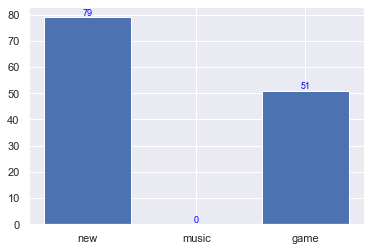

In [25]:
x = ['new', 'music', 'game']
y = [total_category_new_bad, total_category_music_bad, total_category_game_bad]

plt.bar(x, y)
for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()

# &#128198;(04-26, 05-17, 05-28) 날짜 댓글 추가수집
# + music 카테고리는 제외

In [69]:
# 여기서부터
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

In [70]:
df = pd.read_csv("data/csv/04-26/popular_final_sum.csv")
df2 =  pd.read_csv("data/csv/05-17/popular_final_without_music_sum.csv")
df3 = pd.read_csv("data/csv/05-28/popular_final_without_music_sum.csv")
df2[-5:]

,Unnamed: 0,videoId,item_type,authorDisplayName,textDisplay,textOriginal,authorChannelUrl,likeCount,category,isBad
3630,3630,Bb5DKSx5jTI,0,슬라이므,"<a href=""https://www.youtube.com/watch?v=Bb5DK...",7:51 옛날에 한??님 자연재해에서 살아남을려고 했던것 같은데...,http://www.youtube.com/channel/UC2fNlqrRiGPJ2I...,0,game,0
3631,3631,Bb5DKSx5jTI,0,노래가사 알려주는사람,배드(bed)락(rock),배드(bed)락(rock),http://www.youtube.com/channel/UCYRsQLlW3OOmXQ...,2,game,0
3632,3632,Bb5DKSx5jTI,1,정하율,아!,아!,http://www.youtube.com/channel/UCf9Zy9XxvlCDYj...,0,game,0
3633,3633,Bb5DKSx5jTI,0,대악마 눈깔대장루피,너무재밌겠다..!!,너무재밌겠다..!!,http://www.youtube.com/channel/UCtIbI1ASGUF1GS...,0,game,0
3634,3634,Bb5DKSx5jTI,0,변규태,호박집ㅋㅋㅋ,호박집ㅋㅋㅋ,http://www.youtube.com/channel/UCgBprHJEiq2RC5...,0,game,0


In [71]:
# new랑 game만 하기로 함

category_new = df[df['category'] == 'new']
category_new2 = df2[df2['category'] == 'new']
category_new3 = df3[df3['category'] == 'new']
category_game = df[df['category'] == 'game']
category_game2 = df2[df2['category'] == 'game']
category_game3 = df3[df3['category'] == 'game']

category_new_bad = category_new[category_new['isBad'] == 1]['isBad'].count()
category_new_bad2 = category_new2[category_new2['isBad'] == 1]['isBad'].count()
category_new_bad3 = category_new3[category_new3['isBad'] == 1]['isBad'].count()

category_game_bad = category_game[category_game['isBad'] == 1]['isBad'].count()
category_game_bad2 = category_game2[category_game2['isBad'] == 1]['isBad'].count()
category_game_bad3 = category_game3[category_game3['isBad'] == 1]['isBad'].count()

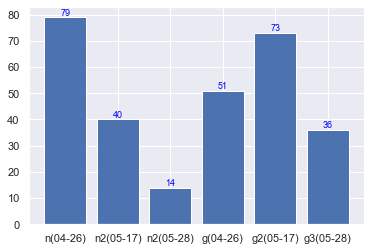

In [72]:
x = ['n(04-26)', 'n2(05-17)', 'n2(05-28)', 'g(04-26)', 'g2(05-17)', 'g3(05-28)']
y = [category_new_bad, category_new_bad2, category_new_bad3, category_game_bad, category_game_bad2, category_game_bad3]

plt.bar(x, y)
for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()

# &#128127;꾸준하게 나쁜 댓글 존재
# &#128101;날짜별 작성자 빈도 워드클라우드

In [77]:
# 날짜별로 isBad==1인 authorDisplayName를 워드클라우드
isBad_author = df[df['isBad'] == 1]["authorDisplayName"]
isBad_author2 = df2[df2['isBad'] == 1]["authorDisplayName"]
isBad_author3 = df3[df3['isBad'] == 1]["authorDisplayName"]
text_isBad_author = isBad_author.values.tolist()
text_isBad_author2 = isBad_author2.values.tolist()
text_isBad_author3 = isBad_author3.values.tolist()

In [78]:
from collections import Counter

dict_isBad_author = dict(Counter(text_isBad_author))
dict_isBad_author2 = dict(Counter(text_isBad_author2))
dict_isBad_author3 = dict(Counter(text_isBad_author3))

In [79]:
from PIL import Image
import numpy as np
from wordcloud import WordCloud

youtube_mask = np.array(Image.open("wordcloud/youtubemask.png"))

wordcloud = WordCloud(
    font_path='wordcloud/NanumSquareRoundB.ttf', 
    width=800, height=800, background_color='black', mask= youtube_mask
)
wordcloud = wordcloud.generate_from_frequencies(dict_isBad_author)
# wordcloud2 = wordcloud.generate_from_frequencies(dict_isBad_author2)
# wordcloud3 = wordcloud.generate_from_frequencies(dict_isBad_author3)

# &#128696;04-26 작성자들

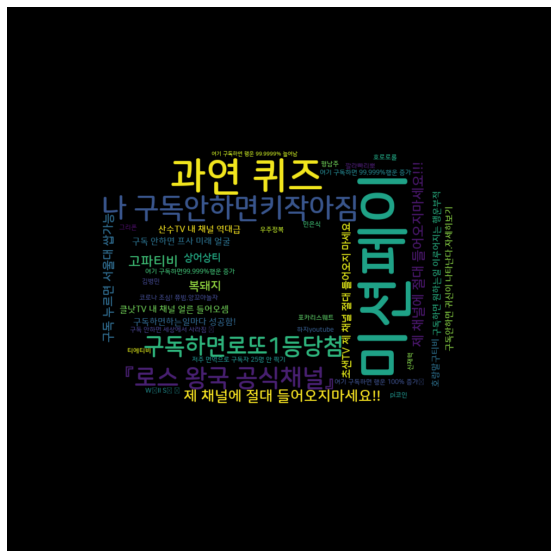

In [80]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.grid(False); plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear") 
plt.show()
# fig.savefig('wordcloud/wordcloud0528.png')

# &#128696;05-17 작성자들

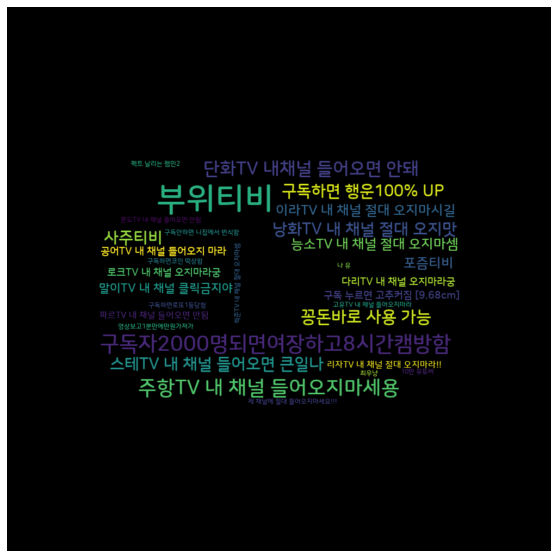

In [81]:
wordcloud2 = wordcloud.generate_from_frequencies(dict_isBad_author2)
fig = plt.figure(figsize=(10, 10))
plt.grid(False); plt.axis("off")
plt.imshow(wordcloud2, interpolation="bilinear") 
plt.show()

# &#128696;05-28 작성자들

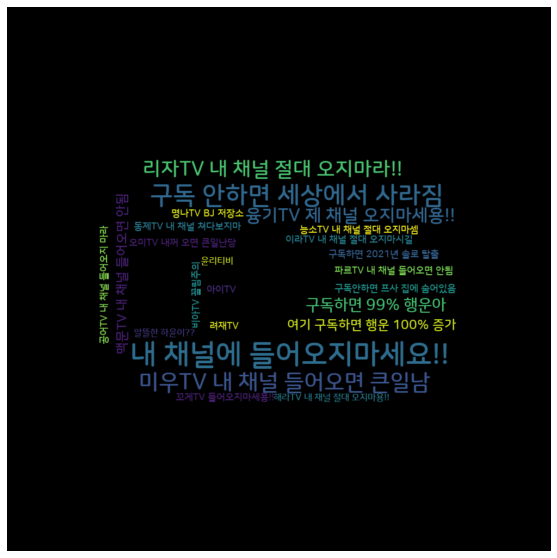

In [82]:
wordcloud3 = wordcloud.generate_from_frequencies(dict_isBad_author3)
fig = plt.figure(figsize=(10, 10))
plt.grid(False); plt.axis("off")
plt.imshow(wordcloud3, interpolation="bilinear") 
plt.show()

# &#9984;&#128069;댓글내용 분석!

In [83]:
# 날짜별로 isBad==1인 textOriginal 추출
isBad_textOriginal = df[df['isBad'] == 1]["textOriginal"]
isBad_textOriginal2 = df2[df2['isBad'] == 1]["textOriginal"]
isBad_textOriginal3 = df3[df3['isBad'] == 1]["textOriginal"]
isBad_textOriginal = isBad_textOriginal.values.tolist()
text_isBad_textOriginal2 = isBad_textOriginal2.values.tolist()
text_isBad_textOriginal3 = isBad_textOriginal3.values.tolist()
isBad_textOriginal[:20]

['제 체널에서 무료로 돈버세요~^^',
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요~^^',
 "남녀갈등/여가부/여야 등 갈등이 없는 가국 유튜브검색 ' 로스왕국 ' \n구독=시민권입니다...",
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요~^^',
 "남녀갈등/여가부/여야 등 갈등이 없는 가국 유튜브검색 ' 로스왕국 ' \n구독=시민권입니다...",
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요~^^',
 '제 체널에서 무료로 돈버세요~^^',
 'https://youtu.be/_ZKl-tZyiRM',
 '구독안하면 영원히 솔로.',
 '구독안하면 영원히 솔로.',
 '제 체널에서 무료로 돈버세요~^^',
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요~^^',
 '구독안하면 영원히 솔로.',
 '제 체널에서 무료로 돈버세요~^^',
 "남녀갈등/여가부/여야 등 갈등이 없는 가국 유튜브검색 ' 로스왕국 ' \n구독=시민권입니다....",
 '구독안하면 영원히 솔로']

In [84]:
import re
# 한글 공백 남김, 자음 모음 제거  
pattern = '[^가-힣 ]|[\t\n\r\f\v]|([ㄱ-ㅎㅏ-ㅣ]+)'
isBad_textOriginal_r = [re.sub(pattern, '', x) for x in isBad_textOriginal]
isBad_textOriginal2_r = [re.sub(pattern, '', x) for x in isBad_textOriginal2]
isBad_textOriginal3_r = [re.sub(pattern, '', x) for x in isBad_textOriginal3]
isBad_textOriginal_r[:20]

['제 체널에서 무료로 돈버세요',
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요',
 '남녀갈등여가부여야 등 갈등이 없는 가국 유튜브검색  로스왕국  구독시민권입니다',
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요',
 '남녀갈등여가부여야 등 갈등이 없는 가국 유튜브검색  로스왕국  구독시민권입니다',
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요',
 '제 체널에서 무료로 돈버세요',
 '',
 '구독안하면 영원히 솔로',
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요',
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요',
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요',
 '남녀갈등여가부여야 등 갈등이 없는 가국 유튜브검색  로스왕국  구독시민권입니다',
 '구독안하면 영원히 솔로']

# &#128548;한국어 자연어 처리 패키지 konlpy
# &#128640;빠른 Mecab으로 명사를 추출해보자!

### 참고링크(설치)
    Mecab부터 깔아보고 konlpy 깔면 금방함. konlpy 깔면서 삽질 엄청함...
#### 1. [Mecab 설치](https://hong-yp-ml-records.tistory.com/91 "Mecab")
#### 2. [Konlpy 설치](https://sdkim817.wordpress.com/2020/01/30/konlpy-%EC%84%A4%EC%B9%98-%EB%B0%8F-%EC%9D%B4%EC%9A%A9/ "Konlpy")  

In [85]:
# 한국어 자연어 처리 패키지 konlpy + 속도빠른? Mecab 설치 
from konlpy.tag import Mecab 
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

print(isBad_textOriginal_r[1])
mecab.nouns(isBad_textOriginal_r[1])

구독안하면 영원히 솔로


['구독', '솔로']

    + 댓글내용에서 명사만 추출해보자~

In [86]:
is_Bad_nouns = []
for text in isBad_textOriginal_r:
    is_Bad_nouns.extend(list(mecab.nouns(text)))
for text in isBad_textOriginal2_r:
    is_Bad_nouns.extend(list(mecab.nouns(text))) 
for text in isBad_textOriginal3_r:
    is_Bad_nouns.extend(list(mecab.nouns(text)))    
print(is_Bad_nouns[:10])
print(is_Bad_nouns[-10:])

['제', '체', '널', '무료', '돈', '버세', '구독', '솔로', '제', '체']
['샤진', '진심', '방송', '의상', '듯', '내', '수', '좌표', '게', '샤진']


    + 한 글자는 다 지우기

In [87]:
is_Bad_nouns = [x for x in is_Bad_nouns if len(x) > 1]
print(is_Bad_nouns[:10])
print(is_Bad_nouns[-10:])

['무료', '버세', '구독', '솔로', '무료', '버세', '남녀', '갈등', '갈등', '가국']
['샤진', '샤진', '샤진', '샤진', '샤진', '진심', '방송', '의상', '좌표', '샤진']


    + 명사 빈도 파악하기

In [88]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns
sns.set()

nouns_counter = Counter(is_Bad_nouns)
top_nouns = dict(nouns_counter.most_common(30))
top_nouns

{'방송': 55,
 '구독': 48,
 '채널': 39,
 '무료': 37,
 '연습생': 36,
 '내유': 35,
 '출신': 34,
 '댓글': 29,
 '아이돌': 24,
 '그룹': 22,
 '하루': 20,
 '샤진': 20,
 '집중': 17,
 '사고': 17,
 '텐션': 17,
 '장난': 17,
 '버세': 16,
 '현질': 16,
 '현직': 16,
 '당신': 15,
 '저주': 15,
 '갈등': 14,
 '행운': 14,
 '프로필': 14,
 '복돼지': 13,
 '가용': 13,
 '솔로': 12,
 '유튜브': 12,
 '수고': 12,
 '방주': 12}

# &#128202;상위 30개 막대그래프로 확인

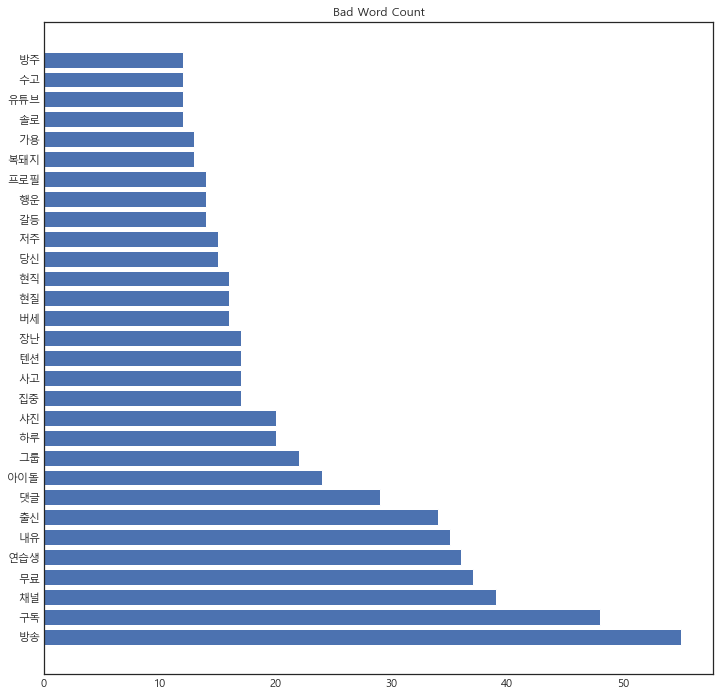

In [89]:
import numpy as np
plt.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 맑은 고딕으로 폰트 설정
matplotlib.rcParams['axes.unicode_minus'] = False #마이너스(-) 폰트 깨짐 방지

y_pos = np.arange(len(top_nouns))

plt.figure(figsize=(12, 12))
plt.barh(y_pos, top_nouns.values())
plt.title('Bad Word Count')
plt.yticks(y_pos, top_nouns.keys())
plt.show()

# &#128530;상위 댓글을 차단된 단어에 등록하면 좋을지도?
![차단댓글](wordcloud/bencomment.png )
# &#128531;그럼 같이 정상적인 댓글도...

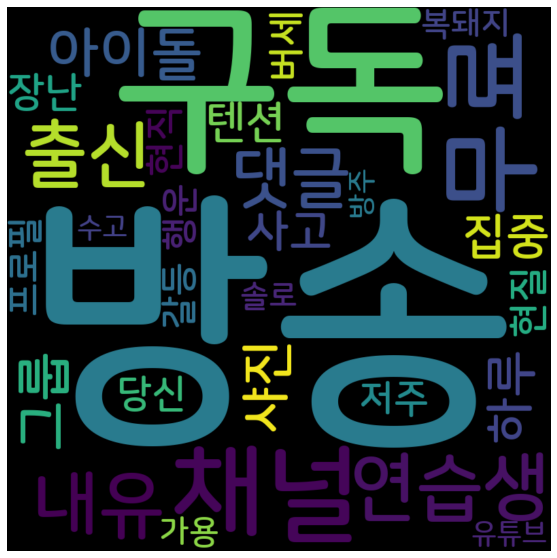

In [314]:
wordcloud = WordCloud(
    font_path='wordcloud/NanumSquareRoundB.ttf', 
    width=800, height=800
)
wordcloud = wordcloud.generate_from_frequencies(top_nouns)

fig = plt.figure(figsize=(10, 10))
plt.grid(False); plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear") 
plt.show()

# 딥러닝을 이용한 자연어 처리
# &#128584; CNN을 이용한 스팸 메일 분류 모델 -> 댓글 분류로???

### 참고

- [유튜브 - 이수안컴퓨터연구소](https://www.youtube.com/watch?v=QejZQ0Dh5x8&list=PL7ZVZgsnLwEEoHQAElEPg7l7T6nt25I3N&index=11 "CNN spam video")

- [wikidocs - 딥러닝을이용한자연어처리입문 ](https://wikidocs.net/80783 "CNN spam wikidocs")

In [173]:
# 분류
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# &#127793;&#128703;댓글 데이터 전처리하기
    1. 수집한 모든 댓글 가져오기
    
    2. 작성자와 댓글내용을 합친 열 생성하기

In [131]:
data = pd.read_csv("data/csv/popular_final_sum.csv")
data["authorAndTextOriginal"] = data["authorDisplayName"] + " " + data["textOriginal"]
data = data.astype({"isBad": 'int',
                    "authorAndTextOriginal" : "str"})
data.head()

,Unnamed: 0,videoId,item_type,authorDisplayName,textDisplay,textOriginal,authorChannelUrl,likeCount,category,isBad,authorAndTextOriginal
0,0,K7qKmZn0XfE,0,big k,힘든시기. 연우 하영이<br />보는재미에 푹 빠져<br />잘 지냈습니다<br /...,힘든시기. 연우 하영이\r\n보는재미에 푹 빠져\r\n잘 지냈습니다\r\n그동안 고...,http://www.youtube.com/channel/UCjDN0NP-BJ1WEP...,151.0,new,0,big k 힘든시기. 연우 하영이\r\n보는재미에 푹 빠져\r\n잘 지냈습니다\r\...
1,1,K7qKmZn0XfE,1,미션페이,제 체널에서 무료로 돈버세요~^^,제 체널에서 무료로 돈버세요~^^,http://www.youtube.com/channel/UCXk7WVpUdr9In1...,0.0,new,1,미션페이 제 체널에서 무료로 돈버세요~^^
2,2,K7qKmZn0XfE,0,임충희,경완님 그동안 많이 고마웠어요<br />항상 행복하시고 연우 하영이 모습 자주보여주...,경완님 그동안 많이 고마웠어요\r\n항상 행복하시고 연우 하영이 모습 자주보여주세요...,http://www.youtube.com/channel/UCajvtubq_aEsGh...,669.0,new,0,임충희 경완님 그동안 많이 고마웠어요\r\n항상 행복하시고 연우 하영이 모습 자주보...
3,3,K7qKmZn0XfE,1,과연 퀴즈,구독안하면 영원히 솔로,구독안하면 영원히 솔로,http://www.youtube.com/channel/UCA8pGSJzLLhRtk...,5.0,new,1,과연 퀴즈 구독안하면 영원히 솔로
4,4,K7qKmZn0XfE,0,김남이,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행...,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행...,http://www.youtube.com/channel/UCbt9l09yFRsvy5...,664.0,new,0,김남이 언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금...


In [132]:
# 필요없는 열 삭제
del data["videoId"]
del data["item_type"]
del data["authorDisplayName"]
del data["textDisplay"]
# del data["textOriginal"]
del data["authorChannelUrl"]
del data["likeCount"]
del data["category"]

data[:10]

,Unnamed: 0,textOriginal,isBad,authorAndTextOriginal
0,0,힘든시기. 연우 하영이\r\n보는재미에 푹 빠져\r\n잘 지냈습니다\r\n그동안 고...,0,big k 힘든시기. 연우 하영이\r\n보는재미에 푹 빠져\r\n잘 지냈습니다\r\...
1,1,제 체널에서 무료로 돈버세요~^^,1,미션페이 제 체널에서 무료로 돈버세요~^^
2,2,경완님 그동안 많이 고마웠어요\r\n항상 행복하시고 연우 하영이 모습 자주보여주세요...,0,임충희 경완님 그동안 많이 고마웠어요\r\n항상 행복하시고 연우 하영이 모습 자주보...
3,3,구독안하면 영원히 솔로,1,과연 퀴즈 구독안하면 영원히 솔로
4,4,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행...,0,김남이 언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금...
5,5,제 체널에서 무료로 돈버세요~^^,1,미션페이 제 체널에서 무료로 돈버세요~^^
6,6,ᆢㅍ#@4@====@Ayden Manuel,0,한은숙 ᆢㅍ#@4@====@Ayden Manuel
7,7,남녀갈등/여가부/여야 등 갈등이 없는 가국 유튜브검색 ' 로스왕국 ' \r\n구독=...,1,『로스 왕국 공식채널』 남녀갈등/여가부/여야 등 갈등이 없는 가국 유튜브검색 ' 로...
8,8,🌷 🌷 \r\n 🌷 🌷\r\n ...,0,뿌용 🌷 🌷 \r\n 🌷 🌷\r...
9,9,구독안하면 영원히 솔로,1,과연 퀴즈 구독안하면 영원히 솔로


In [133]:
len(data)

12463

    + 댓글내용에서 한글, 공백을 제외한 특수문자, 자음, 모음, 다른 언어는 제거
    
    + 다중 공백 제거

In [134]:
import re
# 한글, 공백 제외 영어, 자음, 모음 제거
pattern = '[^가-힣 ]|[\t\n\r\f\v]|([ㄱ-ㅎㅏ-ㅣ]+)'
data["textOriginal"] = data["textOriginal"].map(lambda x : re.sub(pattern, '', x))
data["authorAndTextOriginal"] = data["authorAndTextOriginal"].map(lambda x : re.sub(pattern, '', x))
# 다중 공백 제거
data["textOriginal"] = data["textOriginal"].map(lambda x : re.sub(' +', ' ', x))
data["authorAndTextOriginal"] = data["authorAndTextOriginal"].map(lambda x : re.sub(' +', ' ', x))
data[:10]

,Unnamed: 0,textOriginal,isBad,authorAndTextOriginal
0,0,힘든시기 연우 하영이보는재미에 푹 빠져잘 지냈습니다그동안 고생많이 하셨고요즐거움과 ...,0,힘든시기 연우 하영이보는재미에 푹 빠져잘 지냈습니다그동안 고생많이 하셨고요즐거움과...
1,1,제 체널에서 무료로 돈버세요,1,미션페이 제 체널에서 무료로 돈버세요
2,2,경완님 그동안 많이 고마웠어요항상 행복하시고 연우 하영이 모습 자주보여주세요연우 하...,0,임충희 경완님 그동안 많이 고마웠어요항상 행복하시고 연우 하영이 모습 자주보여주세요...
3,3,구독안하면 영원히 솔로,1,과연 퀴즈 구독안하면 영원히 솔로
4,4,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행복...,0,김남이 언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처...
5,5,제 체널에서 무료로 돈버세요,1,미션페이 제 체널에서 무료로 돈버세요
6,6,,0,한은숙
7,7,남녀갈등여가부여야 등 갈등이 없는 가국 유튜브검색 로스왕국 구독시민권입니다,1,로스 왕국 공식채널 남녀갈등여가부여야 등 갈등이 없는 가국 유튜브검색 로스왕국 구독...
8,8,꽃길,0,뿌용 꽃길
9,9,구독안하면 영원히 솔로,1,과연 퀴즈 구독안하면 영원히 솔로


In [135]:
len(data)

12463

    + 공백이 생긴 행은 제거

In [136]:
# 공백 행 제거
data.replace('', np.nan, inplace=True)
data.replace(' ', np.nan, inplace=True)
data.dropna(inplace=True)

In [137]:
len(data)

10356

# &#127806;전처리 완료
    + authorAndTextOriginal 열을 가지고 진행, 내용은 작성자 + " " + 댓글내용

In [138]:
del data["textOriginal"]
data[:20]

,Unnamed: 0,isBad,authorAndTextOriginal
0,0,0,힘든시기 연우 하영이보는재미에 푹 빠져잘 지냈습니다그동안 고생많이 하셨고요즐거움과...
1,1,1,미션페이 제 체널에서 무료로 돈버세요
2,2,0,임충희 경완님 그동안 많이 고마웠어요항상 행복하시고 연우 하영이 모습 자주보여주세요...
3,3,1,과연 퀴즈 구독안하면 영원히 솔로
4,4,0,김남이 언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처...
5,5,1,미션페이 제 체널에서 무료로 돈버세요
7,7,1,로스 왕국 공식채널 남녀갈등여가부여야 등 갈등이 없는 가국 유튜브검색 로스왕국 구독...
8,8,0,뿌용 꽃길
9,9,1,과연 퀴즈 구독안하면 영원히 솔로
11,11,1,미션페이 제 체널에서 무료로 돈버세요


In [139]:
# data.drop_duplicates(subset=["textOriginal"], inplace=True)
# len(data)

# &#128221;나쁜 댓글과 일반 댓글 

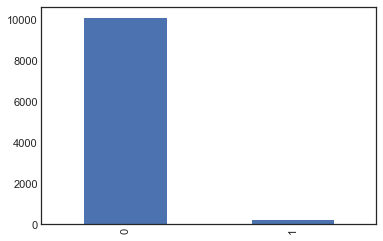

In [140]:
data["isBad"].value_counts().plot(kind="bar")
plt.show()

In [141]:
data.groupby("isBad").size().reset_index(name="count")

,isBad,count
0,0,10095
1,1,261


# &#127830;모델 학습을 위한 데이터 처리
(X_data: 작성자+댓글내용), (Y_data: 0 or 1 로 이루어진 정답 데이터) 로 설정

In [142]:
X_data = data["authorAndTextOriginal"]
Y_data = data["isBad"]

    + 전체 단어의 개수를 1,000개로 제한하고 정수 인코딩을 진행합니다.

In [143]:
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

In [144]:
import pickle
with open('model/tokenizer.pkl', 'wb') as output:
   pickle.dump(tokenizer, output, pickle.HIGHEST_PROTOCOL)

    + 상위 5개의 샘플을 출력해봅시다. 문자가 정수로 인코딩된 결과

In [145]:
sequences[:5]

[[220, 11],
 [126, 26, 616, 382, 617],
 [313, 21, 220, 266, 131, 21],
 [656, 764, 221, 116, 697],
 [48, 7, 313, 618, 413, 27]]

    + 전체 데이터에서 가장 길이가 긴 댓글과 전체 댓글 데이터의 길이 분포

In [146]:
X_data = sequences

print('댓글 최대 길이: {}'.format(max(len(l) for l in X_data)))
print('댓글 평균 길이: {}'.format((sum(map(len, X_data))/len(X_data))))

댓글 최대 길이: 181
댓글 평균 길이: 2.9207222865971416


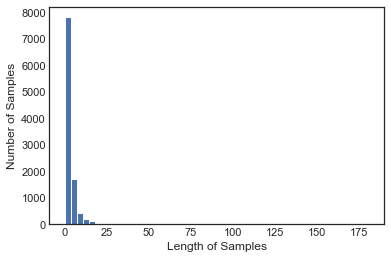

In [147]:
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

    + 가장 긴 댓글의 길이는 181이며, 전체 데이터의 길이 분포는 대체적으로 약 25~30이하의 길이를 가지는 것을 볼 수 있습니다.

In [148]:
max_len = 181
data = pad_sequences(X_data, maxlen=max_len)
print(data.shape)

(10356, 181)


    + maxlen에는 가장 긴 댓글의 길이였던 181이라는 숫자를 넣었습니다.
    
    + 이는 10,356개의 data의 길이를 전부 181로 바꿉니다. 181보다 길이가 짧은 댓글 샘플은 전부 숫자 0이 패딩되어 181의 길이를 가지게 됩니다.

    + 이제 data 데이터는 10,356 × 181의 크기를 갖게됩니다. 이제 n_train과 n_test를 분리합니다.

In [149]:
 n_train = int(len(sequences) * 0.8)
 n_test = int(len(sequences) - n_train)

 print(n_train)
 print(n_test)

8284
2072


    + data를 8:2로 train과 test로 나누어 저장

In [150]:
X_train = data[:n_train]
Y_train = np.array(Y_data[:n_train])
X_test = data[n_train:]
Y_test = np.array(Y_data[n_train:])

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(8284, 181)
(8284,)
(2072, 181)
(2072,)


# &#127867;모델 구성하기
저도 따라한 거라..
자세한 내용은 wikidocs와 유튜브 링크를 참고해주세요.&#128514;


- [유튜브 - 이수안컴퓨터연구소](https://www.youtube.com/watch?v=QejZQ0Dh5x8&list=PL7ZVZgsnLwEEoHQAElEPg7l7T6nt25I3N&index=11 "CNN spam video")

- [wikidocs - 딥러닝을이용한자연어처리입문 ](https://wikidocs.net/80783 "CNN spam wikidocs")

In [162]:
# 모델 구성
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [163]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [164]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('model/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)  # 모델 저장하기

In [165]:
history = model.fit(X_train, Y_train,
                    epochs=10,
                    batch_size=64, 
                    validation_split=0.2, 
                    callbacks=[es, mc])

Epoch 1/10
104/104 [==============================] - 2s 13ms/step - loss: 0.2138 - acc: 0.9657 - val_loss: 0.1226 - val_acc: 0.9753

Epoch 00001: val_acc improved from -inf to 0.97526, saving model to model\best_model.h5
Epoch 2/10
104/104 [==============================] - 1s 12ms/step - loss: 0.1013 - acc: 0.9745 - val_loss: 0.0694 - val_acc: 0.9837

Epoch 00002: val_acc improved from 0.97526 to 0.98371, saving model to model\best_model.h5
Epoch 3/10
104/104 [==============================] - 1s 13ms/step - loss: 0.0435 - acc: 0.9902 - val_loss: 0.0426 - val_acc: 0.9922

Epoch 00003: val_acc improved from 0.98371 to 0.99215, saving model to model\best_model.h5
Epoch 4/10
104/104 [==============================] - 1s 13ms/step - loss: 0.0323 - acc: 0.9920 - val_loss: 0.0391 - val_acc: 0.9922

Epoch 00004: val_acc did not improve from 0.99215
Epoch 5/10
104/104 [==============================] - 1s 12ms/step - loss: 0.0268 - acc: 0.9935 - val_loss: 0.0359 - val_acc: 0.9922

Epoch 0000

# &#128200;모델 평가하기

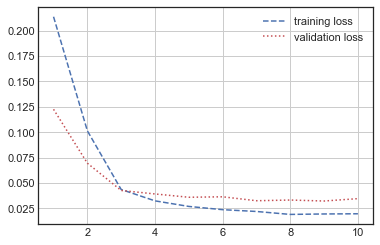

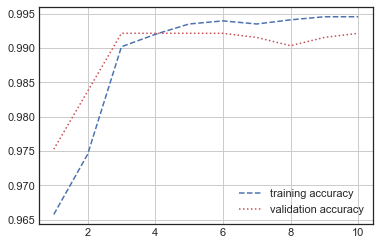

In [166]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b--', label='training loss')
plt.plot(epochs, val_loss, 'r:', label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='training accuracy ')
plt.plot(epochs, val_acc, 'r:', label='validation accuracy')
plt.grid()
plt.legend()
plt.show()

In [167]:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('best_model.h5')
# loaded_model.evaluate(X_test, Y_test)
model.evaluate(X_test, Y_test)

65/65 [==============================] - 0s 2ms/step - loss: 0.0218 - acc: 0.9952


[0.021802743896842003, 0.9951737523078918]

# &#128583;실제 댓글, 모델로 예측하기

In [168]:
# 모델 예측
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

In [174]:
loaded_model = load_model('model/best_model.h5')
with open('model/tokenizer.pkl', 'rb') as input:
    tokenizer = pickle.load(input)
max_len = 181
def predict_comment(new_sentence):
    pattern = '[^가-힣 ]|[\t\n\r\f\v]|([ㄱ-ㅎㅏ-ㅣ]+)'
    new_sentence = re.sub(pattern, '', new_sentence)
    new_token = new_sentence.split()
    new_sequences = tokenizer.texts_to_sequences([new_token])
    new_pad = pad_sequences(new_sequences, maxlen=max_len)
    score = float(loaded_model.predict(new_pad))

    # print("score: ", score)
    if score > 0.5:
        print("- {} -> 나쁨({:.2f}%)".format(new_sentence, score*100))
    else:
        print("- {} -> 괜찮음({:.2f}%)".format(new_sentence, (1-score)*100))

In [175]:
predict_comment("과연 퀴즈 구독안하면 영원히 솔로")
predict_comment("미션페이 제 체널에서 무료로 돈버세요")
predict_comment("과연 퀴즈 구독안하면 영원히 솔로")
predict_comment("미션페이 제 체널에서 무료로 돈버세요")
predict_comment("허준범 너무 재밌고")
predict_comment("사주티비 전직 아이돌 출신 비제이 스타킹 개찢는 방송하넹...")
predict_comment("복잡한 엔지니어링 09:54 근래에 본 편집중에 가장 짜릿했습니다. 편집자님.")
predict_comment("제 채널에 절대 들어오지마세요!!! 제 샤진 절대로 보면 안돼요!!")
predict_comment("신진승 와 이게뭐라고 자꾸 듣게되지 미치겠네")

- 과연 퀴즈 구독안하면 영원히 솔로 -> 나쁨(93.21%)
- 미션페이 제 체널에서 무료로 돈버세요 -> 나쁨(97.51%)
- 과연 퀴즈 구독안하면 영원히 솔로 -> 나쁨(93.21%)
- 미션페이 제 체널에서 무료로 돈버세요 -> 나쁨(97.51%)
- 허준범 너무 재밌고 -> 괜찮음(99.15%)
- 사주티비 전직 아이돌 출신 비제이 스타킹 개찢는 방송하넹 -> 괜찮음(89.64%)
- 복잡한 엔지니어링  근래에 본 편집중에 가장 짜릿했습니다 편집자님 -> 괜찮음(99.15%)
- 제 채널에 절대 들어오지마세요 제 샤진 절대로 보면 안돼요 -> 나쁨(95.13%)
- 신진승 와 이게뭐라고 자꾸 듣게되지 미치겠네 -> 괜찮음(99.16%)


# &#9989;실제 유튜브 댓글API로 확인 후 댓글 차단하기.
## 03_project_eraseData_API.py 파일 실행하기
### https://www.youtube.com/watch?v=49ysegAFDoY

In [172]:
%run 03_project_eraseData_API.py

-  박세진시간 전내가보기에는 피지컬은 원탑이다 -> 괜찮음(99.14%)
-  공어 내 채널 들어오지 마라시간 전헐 엄청 유명한 역대급 너출사고 터진거 같아내유튭에 볼 수 있는좌표 올려뒀으니깐 짤리기전에 봐 -> 나쁨(89.23%)
-  저게 경쟁 솔쿼드라고 뜨뜨님의 한계란 과연 어디까지인것인가 -> 괜찮음(99.15%)
-  천상계 경기 보면 무슨 무협지 같음  -> 괜찮음(99.14%)
-  라뎃형 몸서리 치네  -> 괜찮음(99.14%)
-  알뜰한 하윤이 제 채널 오셔서꽁돈 받아가세용어그로 아니에용 -> 괜찮음(93.75%)
-  중심티비 전직 아이돌 연습생 출신 비제이 스타킹 개찢는 방송하넹내프로필 와서 보고가용 -> 나쁨(85.97%)
-  가치티비 진심 존나 유명한 방송하다가 의상 제대로 내려간듯내꺼 들어오면 볼 수 있는좌표 찍어둘게 -> 나쁨(87.88%)
-  제 채널에 꽁짜로 돈버는법 나와있습니다 -> 괜찮음(93.22%)
-  구독안하면 영원히 잠만잔다 -> 괜찮음(97.46%)
-  제 채널에 절대 들어오지마세요 제 샤진 절대로 보면 안돼요 -> 나쁨(95.13%)
-  전직 아이돌 출신 방송봐 -> 괜찮음(98.44%)
-  구독으로 천명찍기 -> 괜찮음(99.14%)
-  구독하면 행복함 -> 괜찮음(99.14%)
-  제 체널에서 무료로 돈버세요 -> 나쁨(92.99%)
-  졸려죽겠네요 -> 괜찮음(99.14%)
-  반갑습니다 -> 괜찮음(99.14%)
-  난로마놓낭난여 -> 괜찮음(99.14%)
comment_ids:  ['Ugw3aLwZryFHwi8UCr14AaABAg', 'Ugx2moYDmBrpk0oSorR4AaABAg', 'UgweXzZxc1HlcoxeJLp4AaABAg', 'UgzO2maus3WudF3D3LZ4AaABAg', 'UgwzwZBlFI8ljAxHS114AaABAg']
Please visit this URL to authorize this application: https://accounts.google.co

# &#128586;감사합니다!
## + 데이터로 나쁜 댓글들을 다양하게 많이 수집하면 더 정확한 모델을 만들 수 있지 않을까???
## + 영어나 특수문자는 아예 처리를 안하도록 했는데 참신한 댓글은 어찌 처리해야할까???